## This is my adaption of the Keras blog language translation introduction using sequence to sequence learning

## Instead of French I am using English to Japanese as I am currently learning Japanese

## I also included some custom text profilers and loaders I developed for this quick prototype

## I am also using GPU driven LSTMs instead of vanilla LSTMs as to increase training speed

In [1]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
import re

c:\users\samorris\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
# Path to the data txt file on disk.
data_path = 'Japanese-Data/jpn.txt'

In [4]:
### Profile some data

In [5]:
def load_text(data_path): 
    with open(data_path,'r', encoding='utf-8') as f:
        data = f.readlines()
    print("There are {} lines in the text".format(len(data)))
    return data

In [6]:
data = load_text(data_path)

There are 42992 lines in the text


In [7]:
### Word and Phrase Finder
def finder_woph(data, words):
    for word in words:
        for phrase in data:
            if any(re.findall(word, phrase)):
                print("Found")
                print(phrase)

In [8]:
search_words = ["Goodbye"]

In [9]:
finder_woph(data,search_words)

Found
Goodbye!	さようなら！

Found
Goodbye!	さようなら。



In [10]:
search_words_2 = ["Cool"]

In [11]:
finder_woph(data,search_words_2)

Found
Cool off!	頭を冷やせ。

Found
Cool down.	落ち着いて。

Found
Cool down.	頭を冷やせ。



## Set some global variables for the model

1. Batch Size number of training examples for one iteration

2. Epochs number of iterations to train for

3. latent dim is the latent dimensionality of the encoder space for the state sequence used by the decoder

4. num samples if the number of word samples to train on

In [12]:
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000

## Vectorize the data.

In [13]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Loop over the lines and seperate using a tab for the input and output for translation
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]: 
    input_text, target_text = line.split('\t')
    
    # Define start and end sequence of character
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # Create set of all unique characters for the input
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # Create set of all unique characters for the output      
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [14]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [15]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 1483
Max sequence length for inputs: 22
Max sequence length for outputs: 32


In [16]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

## Need to define the 3D array shape of the encoder and decoder

#### 3D Array shape for input is (num_pairs, max_encode_sentence_length, num_encode_characters)

#### 3D Array shape for output is (num_pairs, max_decode_sentence_length, num_decode_characters)

#### Need to then offset the decoder target data by one timestep for training and translation



In [17]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')

decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

## Create input and output text

#### decoder_target_data is ahead of decoder_input_data by one timestep

#### decoder_target_data will be ahead by one timestep and will not include the start character.

In [18]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## Define an input sequence and process it.

#### We are only keeping the states from the encoder as to feed to the decoder

In [19]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = CuDNNLSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

## Set up the decoder, using `encoder_states` as initial state.

## Set the decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.

In [20]:

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Define the model that will turn
## `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 72)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1483)   0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 256), (None, 337920      input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, None, 256),  1782784     input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1]               
          

## Run model training and save model

In [23]:

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.4531 - val_loss: 1.6820
Epoch 2/100
8000/8000 [==============================] - 12s 1ms/step - loss: 1.3040 - val_loss: 1.5137
Epoch 3/100
8000/8000 [==============================] - 12s 1ms/step - loss: 1.1633 - val_loss: 1.3907
Epoch 4/100
8000/8000 [==============================] - 12s 1ms/step - loss: 1.0654 - val_loss: 1.3127
Epoch 5/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.9910 - val_loss: 1.2496
Epoch 6/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.9318 - val_loss: 1.2065
Epoch 7/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.8842 - val_loss: 1.1754
Epoch 8/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.8430 - val_loss: 1.1393
Epoch 9/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.8058 - val_loss: 1.1106
Epoch 10/100
800

8000/8000 [==============================] - 10s 1ms/step - loss: 0.0756 - val_loss: 1.3246
Epoch 79/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.0734 - val_loss: 1.3256
Epoch 80/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0720 - val_loss: 1.3370
Epoch 81/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0711 - val_loss: 1.3367
Epoch 82/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.0688 - val_loss: 1.3414
Epoch 83/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0676 - val_loss: 1.3436
Epoch 84/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0667 - val_loss: 1.3486
Epoch 85/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0652 - val_loss: 1.3570
Epoch 86/100
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0642 - val_loss: 1.3482
Epoch 87/100
8000/8000 [==============================] - 11s 1ms/st

c:\users\samorris\anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


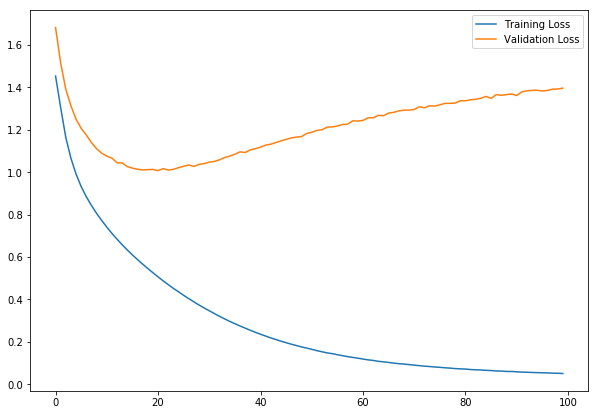

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

## Create Inference Models

In [25]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

## Reverse-lookup token index to decode sequences back to something readable.

In [26]:

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())

reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


## Create decoder sequence function

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Test the decoder output using one sequence from the training set

In [113]:
for seq_index in range(1,10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Hi.
Decoded sentence: こんにちは！

-
Input sentence: Run.
Decoded sentence: 走って！

-
Input sentence: Run.
Decoded sentence: 走って！

-
Input sentence: Who?
Decoded sentence: 誰？

-
Input sentence: Wow!
Decoded sentence: ワォ！

-
Input sentence: Wow!
Decoded sentence: ワォ！

-
Input sentence: Wow!
Decoded sentence: ワォ！

-
Input sentence: Fire!
Decoded sentence: 火事！

-
Input sentence: Fire!
Decoded sentence: 火事！



### Now lets make a custom data loader for translation

In [120]:
english_text_1 = "Hi"

In [121]:
def translate(text):
    translate = np.zeros((1,len(text)+10,num_encoder_tokens))
    for i, char in enumerate(text):
        print(i,char, input_token_index[char])
        translate[0,i,input_token_index[char]] = 1
    japanese = decode_sequence(translate)
    print(japanese)

In [122]:
translate(english_text_1)

0 H 27
1 i 53
負けた。



## I think it needs some work, but for a first prototype it is not too bad....